Github Link: https://github.com/BhavikJoshi/ECE188_ML_Adversary_Project

# Perform an Adversarial attack.

For the second part of the project we consider a trained model (MobileNet) which is trained on the imagenet dataset. 

We use an evasion attack called [FGSM](https://neptune.ai/blog/adversarial-attacks-on-neural-networks-exploring-the-fast-gradient-sign-method#:~:text=The%20Fast%20Gradient%20Sign%20Method%20(FGSM)%20combines%20a%20white%20box,model%20into%20making%20wrong%20predictions.) to fool the neural network into making incorrect predictions.

## Import Packages.

Import the necessary packages we continue to use Tensorflow and Keras

In [ ]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.preprocessing import image

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

## Load the Pretrained model. 

We use the [MobileNetV2](https://arxiv.org/abs/1801.04381) model trained on the [Imagenet](https://www.image-net.org/) dataset. 

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14548992/14536120 [==============================] - 0s 0us/step


### Helper Function for Data Processing


Following functions can be used for data processing. Dont worry about these, just use them. 

In [ ]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## Load an Image. 


Load any image, we consider an image of a Golden Retriever. 

In [ ]:
image_raw = tf.io.read_file('/content/drive/MyDrive/188/p2_images/panda_bear.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


49152/35363 [=========================================] - 0s 0us/step


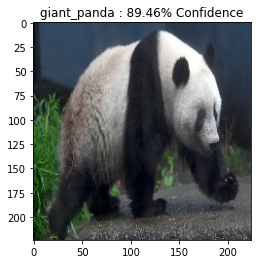

In [ ]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Create the Adversarial Image. 

We use the FGSM method to create an adversarial image. Be sure to read about FGSM to understand how the attack works. 

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(model, input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [ ]:
# Get the input label of the image.
giant_panda_index = 388
label = tf.one_hot(giant_panda_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

NameError: ignored

In [ ]:
def display_images(model, image, description):
  _, label, confidence = get_imagenet_label(model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

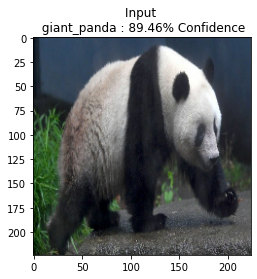

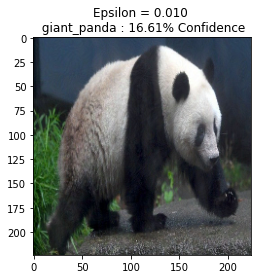

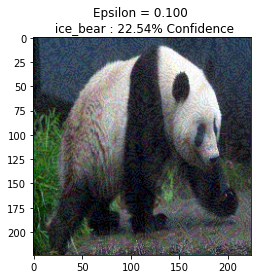

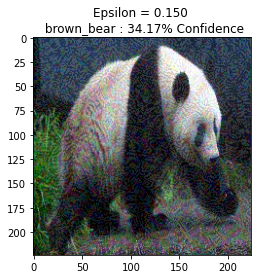

In [ ]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

# Task2: Perform an Analysis to understand the potency of the attack. 

Your task here is to understand how small a change could change the class output and this is measured by the epsilon value needed to change the class. 

Your task is as follows:

* Pick 10 images each from different classes in imagenet. 
* Perform a perturbation analysis on each of these images. 
* In the analysis you are required to report the smallest epsilon value for which you notice a class change. 
* Make a table for each of the images considered with the minimum epsilon value for the FGSM attack. 

Write the Code for the above below. You can add the table also below. 

# # Model 0 (Task 2 MobileNetV2)


In [ ]:
NUM_IMAGES = 10

def display_images(model, image, description):
  _, label, confidence = get_imagenet_label(model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

loss_object = tf.keras.losses.CategoricalCrossentropy()
def create_adversarial_pattern(model, input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

def classify_image(model, model_name, image, name, index):
  truth = get_imagenet_label(model.predict(image))
  assert truth[1] == name
  display_images(model, tf.clip_by_value(image, -1, 1), (model_name + ' w/o pertubation'))

def generate_pertubation(model, model_name, image, name, index):
  label = tf.reshape(tf.one_hot(index, image_probs.shape[-1]), (1, image_probs.shape[-1]))
  pertubation = create_adversarial_pattern(model, tf.clip_by_value(image, -1, 1), label)
  return pertubation

def flip_label(model, model_name, image, name, index, pertubation):
  truth = name
  ep = 0.0
  guess = get_imagenet_label(model.predict(image))[1]
  while truth == guess and ep <= 1:
    ep += 0.001
    adv_image = image + ep*pertubation
    adv_image = tf.clip_by_value(adv_image, -1, 1)
    guess = get_imagenet_label(model.predict(adv_image))[1]
  display_images(model, adv_image, ("Epsilon = " + str(ep)))
  print('With Epsilon = %.3f, %s (index = %d) was misclassified as %s.' % (ep, truth, index, guess))
  return guess, ep

In [ ]:
def ready_image_pretrained(path):
  return preprocess(tf.image.decode_image(tf.io.read_file(path)))

# 10 Images to test on
image_names = ["acoustic_guitar", "baseball", "beagle", "bee", "beer_bottle", "castle", "goldfish", "jellyfish", "peacock", "tiger"]
indicies = [402, 429, 162, 309, 440, 483, 1, 107, 84, 292]

# Load in images
m0_images = []
for name in image_names:
  m0_images.append(ready_image_pretrained("/content/drive/MyDrive/188/p2_images/" + name + ".jpg"))

# Classify clean images, calculate pertubation
m0_pertubations = []
for i in range(NUM_IMAGES):
  classify_image(pretrained_model, "MobileNetV2", m0_images[i], image_names[i], indicies[i])
  m0_pertubations.append(generate_pertubation(pretrained_model, "MobileNetV2", m0_images[i], image_names[i], indicies[i]))



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Find smallest pertubation amount
m0_guesses = []
m0_eps = []
for i in range(NUM_IMAGES):
  guess, ep = flip_label(pretrained_model, "MobileNetV2", m0_images[i], image_names[i], indicies[i], m0_pertubations[i])
  m0_guesses.append(guess)
  m0_eps.append(ep)
    

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import pandas as pd

df = pd.DataFrame({'Images Considered': image_names, "Index" : indicies, "Misclassified Label" : m0_guesses, "Min ε (step = 0.001)": m0_eps})
df

,Images Considered,Index,Misclassified Label,Min ε (step = 0.001)
0,acoustic_guitar,402,electric_guitar,0.071
1,baseball,429,croquet_ball,0.394
2,beagle,162,Walker_hound,0.002
3,bee,309,weevil,0.152
4,beer_bottle,440,sunscreen,0.035
5,castle,483,monastery,0.008
6,goldfish,1,coral_reef,0.007
7,jellyfish,107,parachute,0.002
8,peacock,84,stole,0.283
9,tiger,292,tiger_cat,0.002


The smallest epsilon which elicited a change was 0.002, which misclassified beagle for Walker_hound, jellyfish for parachute, and tiger for tiger_cat.

# Task3: Compare the robustness of the considered model with other models. 

Your task here is to compare how this model (MobileNetV2) compares with other popular object detection models. 

Your task is as follows:

* Consider 5 different models (you can consider various RESNET architectures, any models you find interesting).
* Load the pre-trained weights of the model (trained on imagenet). 
* Perform Task2 on all the considered models. 
* Add all the results in the table. Hence the final table you have 6 columns for each model and epsilon values for each of the 10 images for all 6 models. 


What do you observe? Why do you think this is the case? 

Write the Code for the above below. You can also add the table and answer to the question below. 


# Model 1 : MobileNet

In [ ]:
# Declare Model 1: MobileNet (V1 to compare to V2 in Task 2)
model1 = tf.keras.applications.MobileNet(include_top=True, weights='imagenet')
model1.trainable = False

# Get images
m1_images = []
for name in image_names:
  image = tf.image.decode_image(tf.io.read_file("/content/drive/MyDrive/188/p2_images/" + name + ".jpg"))
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet.preprocess_input(image)
  image = image[None, ...]
  m1_images.append(image)

# Assert that it classifies 10 images correctly, and calculate pertubations
m1_pertubations = []
for i in range(NUM_IMAGES):
  classify_image(model1, "MobileNet", m1_images[i], image_names[i], indicies[i])
  m1_pertubations.append(generate_pertubation(model1, "MobileNet", m1_images[i], image_names[i], indicies[i]))

# Find smallest epsilon
m1_guesses = []
m1_eps = []
for i in range(NUM_IMAGES):
  guess, ep = flip_label(model1, "MobileNet", m1_images[i], image_names[i], indicies[i], m1_pertubations[i])
  m1_guesses.append(guess)
  m1_eps.append(ep)
  

Output hidden; open in https://colab.research.google.com to view.

# Model 2: DenseNet121 (2x as many layers as MobileNet)


In [ ]:
# Declare Model 2: DenseNet121
model2 = tf.keras.applications.DenseNet121(include_top=True, weights='imagenet')
model2.trainable = False

# Get images
m2_images = []
for name in image_names:
  image = tf.image.decode_image(tf.io.read_file("/content/drive/MyDrive/188/p2_images/" + name + ".jpg"))
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.densenet.preprocess_input(image)
  image = image[None, ...]
  m2_images.append(image)

# Assert that it classifies 10 images correctly, and calculate pertubations
m2_pertubations = []
for i in range(NUM_IMAGES):
  classify_image(model2, "DenseNet121", m2_images[i], image_names[i], indicies[i])
  m2_pertubations.append(generate_pertubation(model2, "DenseNet121", m2_images[i], image_names[i], indicies[i]))

# Find smallest epsilon
m2_guesses = []
m2_eps = []
for i in range(NUM_IMAGES):
  guess, ep = flip_label(model2, "DenseNet121", m2_images[i], image_names[i], indicies[i], m2_pertubations[i])
  m2_guesses.append(guess)
  m2_eps.append(ep)
  

Output hidden; open in https://colab.research.google.com to view.

# Model 3: ResNet50V2

In [ ]:
# Declare Model 3: ResNet50V2
model3 = tf.keras.applications.ResNet50V2(include_top=True, weights='imagenet')
model3.trainable = False

# Get images
m3_images = []
for name in image_names:
  image = tf.image.decode_image(tf.io.read_file("/content/drive/MyDrive/188/p2_images/" + name + ".jpg"))
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.resnet_v2.preprocess_input(image)
  image = image[None, ...]
  m3_images.append(image)

# Assert that it classifies 10 images correctly, and calculate pertubations
m3_pertubations = []
for i in range(NUM_IMAGES):
  classify_image(model3, "ResNet50V2", m3_images[i], image_names[i], indicies[i])
  m3_pertubations.append(generate_pertubation(model3, "ResNet50V2", m3_images[i], image_names[i], indicies[i]))

# Find smallest epsilon
m3_guesses = []
m3_eps = []
for i in range(NUM_IMAGES):
  guess, ep = flip_label(model3, "ResNet50V2", m3_images[i], image_names[i], indicies[i], m3_pertubations[i])
  m3_guesses.append(guess)
  m3_eps.append(ep)
  

Output hidden; open in https://colab.research.google.com to view.

# Model 4: Xception (Not super deep but lots of parameters, and higher resolution)


In [ ]:
# Declare Model 4: Xception
model4 = tf.keras.applications.Xception(include_top=True, weights='imagenet')
model4.trainable = False

# Get images
m4_images = []
for name in image_names:
  image = tf.image.decode_image(tf.io.read_file("/content/drive/MyDrive/188/p2_images/" + name + ".jpg"))
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (299, 299))
  image = tf.keras.applications.xception.preprocess_input(image)
  image = image[None, ...]
  m4_images.append(image)

# Assert that it classifies 10 images correctly, and calculate pertubations
m4_pertubations = []
for i in range(NUM_IMAGES):
  classify_image(model4, "Xception", m4_images[i], image_names[i], indicies[i])
  m4_pertubations.append(generate_pertubation(model4, "Xception", m4_images[i], image_names[i], indicies[i]))

# Find smallest epsilon
m4_guesses = []
m4_eps = []
for i in range(NUM_IMAGES):
  guess, ep = flip_label(model4, "Xception", m4_images[i], image_names[i], indicies[i], m4_pertubations[i])
  m4_guesses.append(guess)
  m4_eps.append(ep)
  

Output hidden; open in https://colab.research.google.com to view.

# Model 5: InceptionResNetV2 (very deep)

In [ ]:
def flip_label2(model, model_name, image, name, index, pertubation):
  truth = name
  ep = 0.0
  guess = get_imagenet_label(model.predict(image))[1]
  while truth == guess and ep <= 1:
    ep += 0.01
    adv_image = image + ep*pertubation
    adv_image = tf.clip_by_value(adv_image, -1, 1)
    guess = get_imagenet_label(model.predict(adv_image))[1]
  display_images(model, adv_image, ("Epsilon = " + str(ep)))
  print('With Epsilon = %.3f, %s (index = %d) was misclassified as %s.' % (ep, truth, index, guess))
  return guess, ep

In [ ]:
# Declare Model 5: InceptionResNetV2
model5 = tf.keras.applications.InceptionResNetV2(include_top=True, weights='imagenet')
model5.trainable = False

# Get images
m5_images = []
for name in image_names:
  image = tf.image.decode_image(tf.io.read_file("/content/drive/MyDrive/188/p2_images/" + name + ".jpg"))
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (299, 299))
  image = tf.keras.applications.inception_resnet_v2.preprocess_input(image)
  image = image[None, ...]
  m5_images.append(image)

# Assert that it classifies 10 images correctly, and calculate pertubations
m5_pertubations = []
for i in range(NUM_IMAGES):
  classify_image(model5, "InceptionResNetV2", m5_images[i], image_names[i], indicies[i])
  m5_pertubations.append(generate_pertubation(model5, "InceptionResNetV2", m5_images[i], image_names[i], indicies[i]))

# Find smallest epsilon
m5_guesses = []
m5_eps = []
for i in range(NUM_IMAGES):
  guess, ep = flip_label2(model5, "InceptionResNetV2", m5_images[i], image_names[i], indicies[i], m5_pertubations[i])
  m5_guesses.append(guess)
  m5_eps.append(ep)
  

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
models = ["MobileNetV2", "MobileNet", "DenseNet121", "ResNet50V2", "Xception", "InceptionResNetV2"]
params = ["3.5M", "4.3M", "8.1M", "25.6M", "22.9M", "55.9M"]
depths = [105, 55, 242, 103, 81, 449]

inf = pd.DataFrame({'Model': models, "Index" : params, "Depth" : depths})
inf

,Model,Index,Depth
0,MobileNetV2,3.5M,105
1,MobileNet,4.3M,55
2,DenseNet121,8.1M,242
3,ResNet50V2,25.6M,103
4,Xception,22.9M,81
5,InceptionResNetV2,55.9M,449


In [ ]:
df = pd.DataFrame({'Images Considered': image_names, "Index" : indicies, 
                   "MobileNetV2 Guess" : m0_guesses, "MobileNetV2 Min ε ": m0_eps,
                   "MobileNet Guess" : m1_guesses, "MobileNet Min ε ": m1_eps,
                   "DenseNet121 Guess" : m2_guesses, "DenseNet121 Min ε ": m2_eps,
                   "ResNet50V2 Guess" : m3_guesses, "ResNet50V2 Min ε ": m3_eps,
                   "Xception Guess" : m4_guesses, "Xception Min ε ": m4_eps,
                   "InceptionResNetV2 Guess" : m5_guesses, "InceptionResNetV2 Min ε ": m5_eps
                   })
df


,Images Considered,Index,MobileNetV2 Guess,MobileNetV2 Min ε,MobileNet Guess,MobileNet Min ε,DenseNet121 Guess,DenseNet121 Min ε,ResNet50V2 Guess,ResNet50V2 Min ε,Xception Guess,Xception Min ε,InceptionResNetV2 Guess,InceptionResNetV2 Min ε
0,acoustic_guitar,402,electric_guitar,0.071,electric_guitar,0.008,electric_guitar,0.302,electric_guitar,0.007,banjo,0.540,shovel,0.63
1,baseball,429,croquet_ball,0.394,sombrero,0.336,baseball,1.000,coil,0.660,chambered_nautilus,0.515,sea_urchin,0.77
2,beagle,162,Walker_hound,0.002,Walker_hound,0.005,English_foxhound,0.005,Walker_hound,0.006,English_foxhound,0.005,Walker_hound,0.64
3,bee,309,weevil,0.152,fly,0.003,cockroach,0.140,honeycomb,0.191,tarantula,0.020,cockroach,0.11
4,beer_bottle,440,sunscreen,0.035,sunscreen,0.001,pop_bottle,0.001,pop_bottle,0.002,pop_bottle,0.015,eggnog,0.01
5,castle,483,monastery,0.008,monastery,0.003,monastery,0.011,palace,0.007,monastery,0.006,suspension_bridge,0.01
6,goldfish,1,coral_reef,0.007,coral_reef,0.007,coral_reef,0.027,starfish,0.132,starfish,0.355,starfish,0.29
7,jellyfish,107,parachute,0.002,parachute,0.002,parachute,0.013,parachute,0.006,brain_coral,0.392,starfish,0.82
8,peacock,84,stole,0.283,cardigan,0.009,bow_tie,0.035,cardigan,0.101,stingray,0.412,swimming_trunks,0.58
9,tiger,292,tiger_cat,0.002,tiger_cat,0.001,tiger_cat,0.006,spiny_lobster,0.514,zebra,0.051,tiger_cat,0.02


One observation is that the shallowest network, MobileNet, had very small epsilon values ( < .01) for all but one of the images in order to misclassify. On the other hand InceptionResNetV2, the deepest network, had several images which required very high epsilon values in order to get a wrong label. MobileNet has 55 layers and InceptionResNetV2 has 449 layers. The depth of the network probably plays a role in its robustess to noise. However, ResNet50V2 has 103 layers as opposed to DenseNet121's 242, but ResNet50V2 required larger epsilon values in order to flip the labels; ResNet50V2 has 25.6M parameters and DenseNet121 has 8.1M. Thus, from these two observations, it seems that very deep network and very large networks (lots of nodes and thus lots of parameters) are harder to attack. This makes sense because these models are more complex and thus can probably classify even with a significant amount of noise.
 

# BONUS: Can you provide a better attack?

Can you design a better attack that lowers the epsilon required for the images?

Task:

* Design another attack. 
* Compare the epsilon values on 10 images. 
* Does it perform better than the FGSM attack? That is, does it have lower epsilon values?

Write the code and provide your answers below. 